<a href="https://colab.research.google.com/github/swa08/Classification-model/blob/main/Anomaly_dect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/content/ec2_cpu_utilization_5f5533.csv')
data.info()

print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
Index(['timestamp', 'value'], dtype='object')


In [27]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data['label'] = np.random.randint(0, 2, size=len(data))
data.head()

,value,label
timestamp,,
2014-02-14 14:27:00,51.846,1
2014-02-14 14:32:00,44.508,0
2014-02-14 14:37:00,41.244,0
2014-02-14 14:42:00,48.568,1
2014-02-14 14:47:00,46.714,0


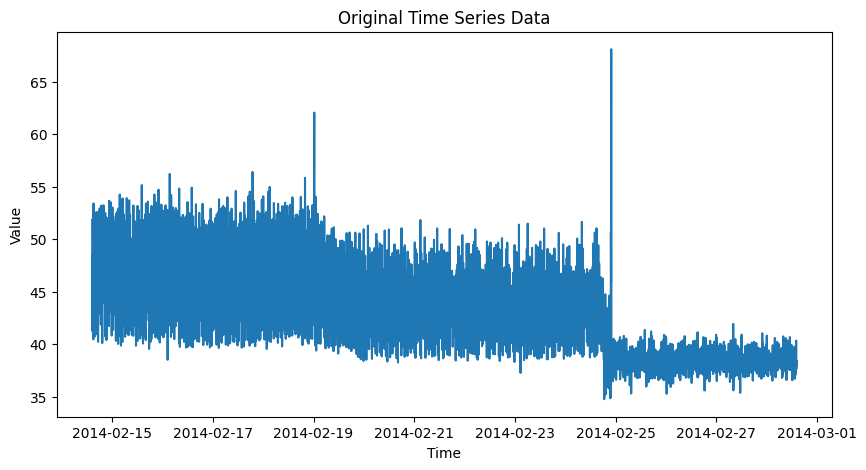

In [28]:
#visualizing original time series data
plt.figure(figsize=(10, 5))
plt.plot(data['value'])
plt.title('Original Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [29]:
#detecting anomalies
def detect_anomalies(df, column, window=10, threshold=2):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()

    # Define anomaly conditions (spike, drop, drift)
    anomalies_spike = df[column] > rolling_mean + threshold * rolling_std
    anomalies_drop = df[column] < rolling_mean - threshold * rolling_std
    anomaly_drift = (df[column] - rolling_mean).abs() > threshold * rolling_std / 2

    return anomalies_spike, anomalies_drop, anomaly_drift
#spike, drop = detect_anomalies(data, 'value', window=10, threshold=2)
spike, drop, drift = detect_anomalies(data, 'value')


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

data['predicted_anomaly'] = 0
data.loc[spike | drop, 'predicted_anomaly'] = 1

# Calculate Precision, Recall, and F1 Score
precision = precision_score(data['label'], data['predicted_anomaly'])
recall = recall_score(data['label'], data['predicted_anomaly'])
f1 = f1_score(data['label'], data['predicted_anomaly'])

# Print Precision, Recall, and F1 Score
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.48
Recall: 0.02
F1 Score: 0.04


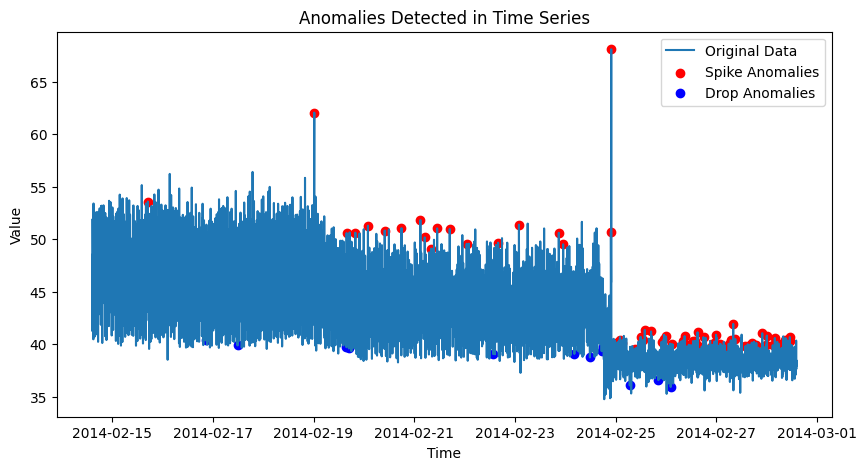

In [31]:
# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(data['value'], label='Original Data')
plt.scatter(data.index[spike], data['value'][spike], color='red', label='Spike Anomalies')
plt.scatter(data.index[drop], data['value'][drop], color='blue', label='Drop Anomalies')
#plt.scatter(data.index[drift], data['value'][drift], color='green', label='Drift Anomalies')
plt.title('Anomalies Detected in Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [32]:
import numpy as np
# categorize and score anomalies
def categorize_anomalies(spike, drop, drift):
    categories = []
    severity_scores = []
    for s, d, dr in zip(spike, drop, drift):
        if s:
            categories.append('Spike')
            severity_scores.append(8 + np.random.random())  # High severity for spikes
        elif d:
            categories.append('Drop')
            severity_scores.append(7 + np.random.random())  # High severity for drops
        elif dr:
            categories.append('Drift')
            severity_scores.append(5 + np.random.random())  # Medium severity for drifts
        else:
            categories.append('Normal')
            severity_scores.append(0)
    return categories, severity_scores


categories, severity_scores = categorize_anomalies(spike, drop, drift)

# Create a DataFrame with anomalies
anomaly_report = pd.DataFrame({
    'Timestamp': data.index,
    'CPU Utilization': data['value'],
    'Anomaly Category': categories,
    'Severity Score': severity_scores
})

# Save to CSV
anomaly_report.to_csv('anomaly_report.csv', index=False)


In [33]:
import plotly.graph_objs as go
fig = go.Figure()

# Plot CPU Utilization
fig.add_trace(go.Scatter(x=anomaly_report['Timestamp'], y=anomaly_report['CPU Utilization'],
                         mode='lines', name='CPU Utilization'))

# Highlight anomalies
anomalies = anomaly_report[anomaly_report['Anomaly Category'] != 'Normal']
fig.add_trace(go.Scatter(x=anomalies['Timestamp'], y=anomalies['CPU Utilization'], mode='markers',
                         marker=dict(color='red', size=10), name='Anomalies'))

fig.update_layout(title='CPU Utilization with Detected Anomalies',
                  xaxis_title='Time', yaxis_title='CPU Usage (%)')

fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

